In [1]:
import sys, os, glob
sys.path.append('/home/gddaslab/mxp140/tcr_project_ultimate')
from constants import patient_names

In [5]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

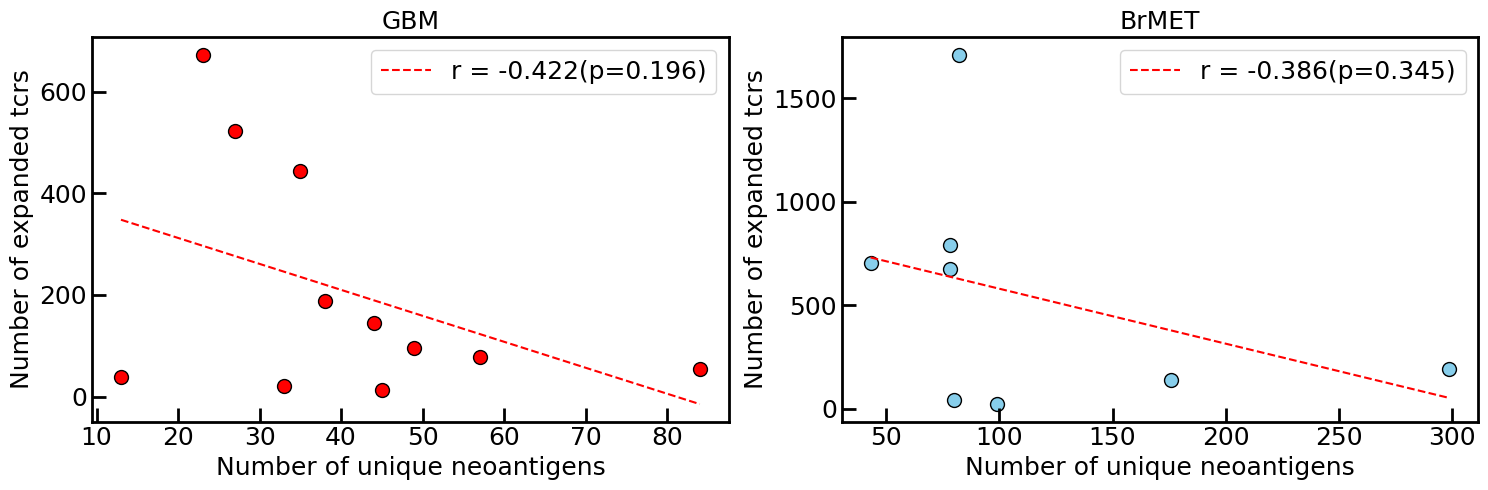

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
tcr_df = pd.read_csv(
    "/home/gddaslab/mxp140/tcr_project_ultimate/data/BrMET_and_GBM_data-PANPEP.csv",
    sep=",",
)
threshold_clone_size = 5
df = pd.DataFrame([], columns=["patient", "unique_tcr_count", "unique_peptide_count"])
for patient_id in patient_names[:]:
    neoantigen_info_df = pd.read_csv(
        f"/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv",
        sep=",",
        comment="#",
    )
    data_config = tcr_df[tcr_df["Patient"] == f"{patient_id}"]["counts"].values

    number_of_expanded_distinct_tcrs = np.sum(data_config >= threshold_clone_size)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [
                    {
                        "patient": f"{patient_id}",
                        "unique_tcr_count": number_of_expanded_distinct_tcrs,
                        "unique_peptide_count": neoantigen_info_df["Peptide"].nunique(),
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
df_gbm = df[df["patient"].str.contains("GBM")]
df_brmet = df[df["patient"].str.contains("BrMET")]

axes[0].scatter(
    df_gbm["unique_peptide_count"],
    df_gbm["unique_tcr_count"],
    s = 100,
    facecolor="red",
    edgecolor="black",
)
axes[0].set_title("GBM", fontsize=18)
axes[0].set_xlabel("Number of unique neoantigens", fontsize=18)
axes[0].set_ylabel("Number of expanded tcrs", fontsize=18)
# Calculate Pearson correlation coefficient and plot the regresssion line
slope, intercept, r_value, p_value, _ = linregress(
    df_gbm["unique_peptide_count"].astype(float),
    df_gbm["unique_tcr_count"].astype(float),
)
x_vals = np.linspace(
    df_gbm["unique_peptide_count"].min(), df_gbm["unique_peptide_count"].max(), 1000
)
y_vals = slope * x_vals + intercept
axes[0].plot(
    x_vals, y_vals, "--", color="red", label=f"r = {r_value:.3f}(p={p_value:.3f})"
)
axes[0].legend(loc="best", fontsize=18)

axes[1].scatter(
    df_brmet["unique_peptide_count"],
    df_brmet["unique_tcr_count"],
    s =100,
    facecolor="skyblue",
    edgecolor="black",
)
axes[1].set_title("BrMET", fontsize=18)
axes[1].set_ylabel("Number of expanded tcrs", fontsize=18)
# Calculate Pearson correlation coefficient and plot the regresssion line
slope, intercept, r_value, p_value, _ = linregress(
    df_brmet["unique_peptide_count"].astype(float),
    df_brmet["unique_tcr_count"].astype(float),
)
x_vals = np.linspace(
    df_brmet["unique_peptide_count"].min(), df_brmet["unique_peptide_count"].max(), 1000
)
y_vals = slope * x_vals + intercept
axes[1].plot(
    x_vals, y_vals, "--", color="red", label=f"r = {r_value:.3f}(p={p_value:.3f})"
)
axes[1].legend(loc="best", fontsize=18)
axes[1].set_ylabel("Number of expanded tcrs", fontsize=18)
axes[1].set_xlabel("Number of unique neoantigens", fontsize=18)

for ax in axes:
    ax.tick_params(
        axis="x", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(axis="x", which="minor", direction="in", length=5, width=2, labelsize=18)
    ax.tick_params(
        axis="y", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(axis="y", which="minor", direction="in", length=5, width=2, labelsize=18)
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()

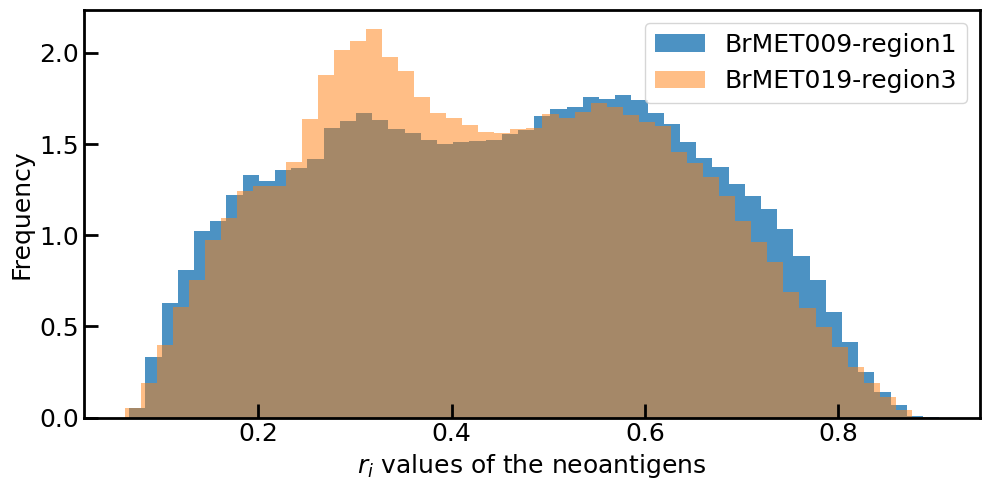

In [10]:
patient = ["BrMET009", "BrMET019"]
region = [1, 3]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
for i, (patient_id, region_number) in enumerate(zip(patient, region)):
    neoantigen_info_df = pd.read_csv(
        f"/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv",
        sep=",",
        comment="#",
    )
    relevant_neoantigen_info_df = neoantigen_info_df[
        ["Peptide", "Score", f"region{region_number}"]
    ]
    relevant_neoantigen_info_df = relevant_neoantigen_info_df[
        relevant_neoantigen_info_df[f"region{region_number}"] == "Yes"
    ]
    ri_values = relevant_neoantigen_info_df["Score"].values
    ax.hist(ri_values, bins=50, alpha=0.8 if i==0 else 0.5, density=True, label=f"{patient_id}-region{region_number}")
    # ax.set_title(f"Histogram of r_i values")
    ax.set_xlabel("$r_i$ values of the neoantigens", fontsize=18)
    ax.set_ylabel("Frequency", fontsize=18)
    # Add text showing number of unique peptides and number of expanded tcrs
    with h5py.File(
        f"/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_region{region_number}_model_results_from_panpep.h5",
        "r",
    ) as file:
        data_config = file["data_config"][:]
        number_of_expanded_distinct_tcrs = np.sum(data_config > 1)
    n_peptides = relevant_neoantigen_info_df["Peptide"].nunique()
ax.legend(loc='best', fontsize=18)
ax.tick_params(
    axis="x", which="major", direction="in", length=10, width=2, labelsize=18
)
ax.tick_params(axis="x", which="minor", direction="in", length=5, width=2, labelsize=18)
ax.tick_params(
    axis="y", which="major", direction="in", length=10, width=2, labelsize=18
)
ax.tick_params(axis="y", which="minor", direction="in", length=5, width=2, labelsize=18)

for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.show()